<h1> Neual Network Tests - yahE vs. minD </h1> <h2> Daniela Koch - January 2020 </h2>



In this project I will be using statistics and neural networks to investigate asymmetries in protein distribution after cell division in E. Coli cells. Different types of protein are distributed differently within the cell throughout the cell cycle - some are fairly unifiomly distributed while some exhibit a time dependent structure. The location and dynamics of these proteins are crucial to cellular function are not yet well understood on cellular scale. 


<h4> My Data </h4>
The data set collected previously by our lab is publicly available at http://mtshasta.phys.washington.edu/aska2/html/gene.html. The data files are .m files (MATLAB code) and contain substantially more information than is relevant to the scope of this project. 

The images used in this notebook are .png files of the first image for the 'consensus tower' of each cell. I constructed a consensus image for each cell individually rather than averaging over many cells. This allows us to work with cells of the same size and with normalized pixel values. 

I have not yet standardized the number of frames used for each consensus image - rather, each cell's cycle has been split into 8 segments (regardless of the cell's lifetime).

This process took place in MATLAB and is therefore not included in this notebook, but the relevant information used in this process can be found at https://github.com/wiggins-lab/SuperSegger/wiki/The-cell-data-files



I will build supervised neural network to classify cell images based on protein labels. 
For now, I will be distinguishing between only two different proteins - yahE and minD.

In [49]:
import numpy as np
import pandas as pd
import tensorflow
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=0.8, 
        context="paper", 
        style="ticks", 
        rc={"axes.linewidth": 0.8})
sns.set_palette("Set2", 3)

%matplotlib inline

<h4> Import the Data</h4>

My data set for this part of the project is comprised of 925 images of yahE and 1432 images of minD. 

In [50]:
import PIL
from PIL import Image

image=Image.open('Image_Prep/minD/minD_t1_1.png')
print(image.format)
print(image.mode)
print(image.size)
# show the image
image.show()

PNG
L
(28, 11)


To import the data we will use matplotlib directly (rather than PIL which keeps the files as .PNG). In this step we import the data and convert it to a python array.

In [51]:
import glob
from matplotlib import image
from matplotlib import pyplot


minD_im=[]
yahE_im=[]

for im_path in glob.glob("Image_Prep/minD/minD_t1_*.png"):
    im = image.imread(im_path)
    minD_im.append(im)

for im_path2 in glob.glob("Image_Prep/yahE/yahE_t1_*.png"):
    im2 = image.imread(im_path2)
    yahE_im.append(im2)



<h5> Check to see that dimensions are the same </h5>



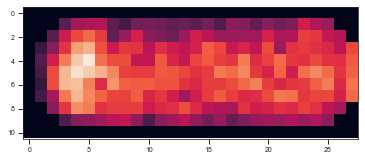

float32
float32
(11, 28)


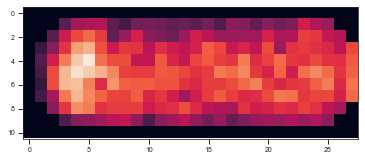

In [52]:
# load and display an image with Matplotlib
from matplotlib import image
from matplotlib import pyplot
# load image as pixel array

pyplot.imshow(minD[1])
pyplot.show()

print(minD[1].dtype)


data = image.imread('Image_Prep/minD/minD_t1_1.png')

# summarize shape of the pixel array
print(data.dtype)
print(data.shape)

# display the array of pixels as an image
pyplot.imshow(data)
pyplot.show()


<h4> Image Dimensions</h4>

Find shape of image to use in neural net. We need to ensure that the dimensions of all images are the same.

In [53]:
print(minD_im[1].shape)
print(yahE_im[1].shape)

(11, 28)
(11, 28)


<h4> Plot a sample of the data</h4>
Let's take a look at a sample image of  each protein: its a little difficult to see, but he the minD shows greater fluorescence towards the left hand side of the cell, whereas the yahE appears fairly uniform throughout the cell. 

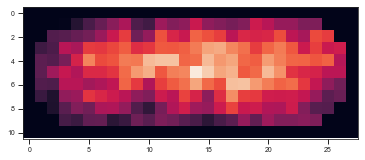

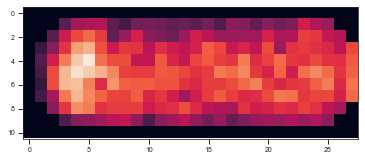

In [54]:
plt.figure(1)
plt.imshow(yahE_im[10])

plt.figure(2)
plt.imshow(minD_im[10])

<h4> Divide data into training and test sets </h4>

Now we have to divide our data into training and test data. We will take 800 from each type of cell for a total training set of 1600 samples

In [55]:
yahE_train=yahE_im[0:800]
minD_train=minD_im[0:800]

yahE_test=yahE_im[800:925]
minD_test=minD_im[800:925]

I want to combine these two training sets into one list. Rather than just appending one to the end of the other, I will combine them to alternate between yahE and minD. This is so that when we train the network, we don't overfit for yahE before introducing minD. The following is a demonstration of how I will combine the sets

In [56]:
list1=[0,0,0,0]
list2=[1,1,1,1]


def countList(lst1, lst2): 
    return [sub[item] for item in range(len(lst2)) 
                    for sub in [lst1, lst2]] 

print(countList(list1,list2))

[0, 1, 0, 1, 0, 1, 0, 1]


Use this function to combine the lists

In [57]:
training_data=np.array(countList(yahE_train,minD_train))

#make sure its the same length
print(len(training_data))


1600


For the sake of our network, we need to assign values to our 'labels' and make an array. Then we will use LabelEncoder to assign numerical values to the labels

In [58]:
yahE_label=0
minD_label=1

labels=[0, 1]

label_array=np.array(labels*800)
#this is now a list comprised of 1600 elements matching those in the training data (ie they alternate)

from keras.utils import np_utils

num_classes=2
# One-hot encoding
training_labels = np_utils.to_categorical(label_array, num_classes)



Using Theano backend.


Now we have to do the same thing for the training data - but it doesn't matter what order the test data is in so we will just append them

In [68]:
test_data_list=yahE_test+minD_test

test_data= np.array(test_data_list)


zeros=[0]*125
ones=[1]*125
test_label_array=np.array(zeros+ones)

#make sure they are the same length

test_labels = np_utils.to_categorical(test_label_array, num_classes)


len(test_data_list)


250

In [70]:
training_data_reshape=np.reshape(training_data,(1600,308))


#have to flatten the images

test_data_reshape=np.reshape(test_data,(250,308))
test_data_reshape.shape


(250, 308)

<h3> Plot the Data</h3>


/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


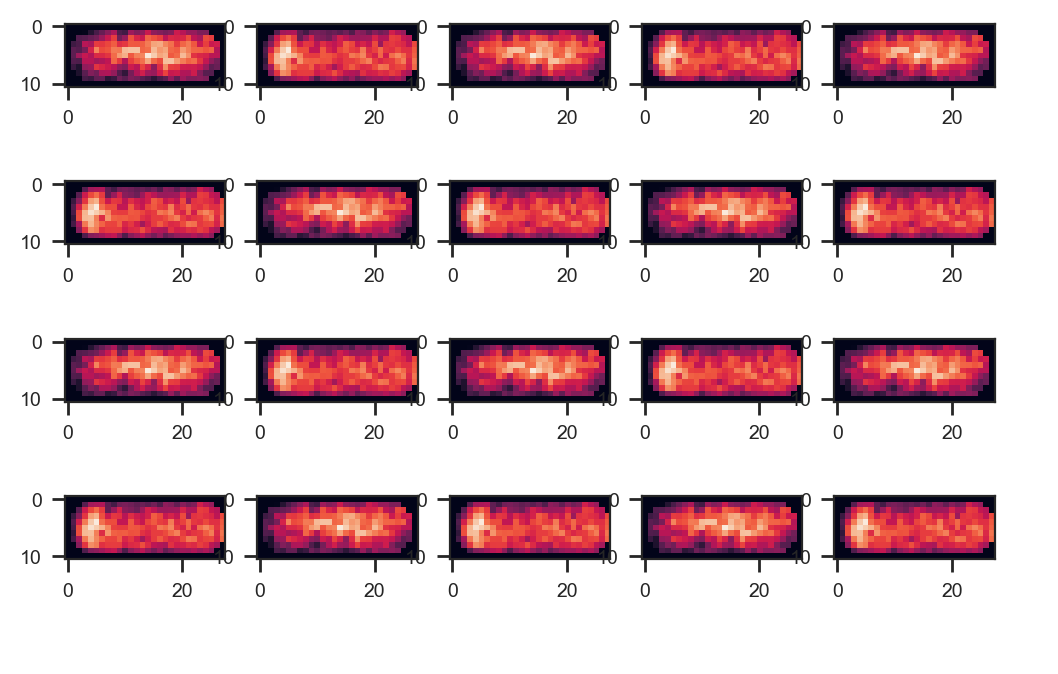

In [71]:
num_samples = 20 # multiple of 5
num_train_samples=1600
selection = np.random.choice(np.arange(0, num_train_samples), 
                             size=num_samples,
                             replace=False)



fig, ax = plt.subplots(int(num_samples/5), 5, dpi=200)
for i, (a, s) in enumerate(zip(ax.ravel(), selection)):
    a.imshow(training_data[i, :, :])
    a.text(23, 26, training_labels[s], color="w")
 


<h2> Building the Neural Network</h2>

In [76]:
num_classes=2
num_rows=11
num_cols=28


from keras.models import Sequential
from keras.layers import Dense # A fully connected layer

BATCH_SIZE = 50# The number of samples to run through the network before the weights / gradient are updated
EPOCHS = 5 # The number of times to iterate through the complete sample of training data 

model = Sequential()
model.add(Dense(num_classes, 
                activation="softmax", # See: https://keras.io/activations/
                input_shape=(num_rows * num_cols,))) 

In [77]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2)                 618       
Total params: 618
Trainable params: 618
Non-trainable params: 0
_________________________________________________________________


In [78]:
model.compile(loss='categorical_crossentropy', # See: https://keras.io/losses/
              optimizer='rmsprop', # See: https://keras.io/optimizers/
              metrics=['accuracy'])

Next, we train the model on training data, validate on test data

In [79]:
score = model.evaluate(test_data_reshape, test_labels, 
                       batch_size=BATCH_SIZE, 
                       verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

250/250 [==============================] - 0s 88us/step
Test loss: 0.6938733100891114
Test accuracy: 0.5


In [80]:
history = model.fit(training_data_reshape, training_labels,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=(test_data_reshape, test_labels))

Train on 1600 samples, validate on 250 samples
Epoch 1/5
1600/1600 [==============================] - 0s 24us/step - loss: 0.4210 - accuracy: 0.9669 - val_loss: 0.2631 - val_accuracy: 1.0000
Epoch 2/5
1600/1600 [==============================] - 0s 26us/step - loss: 0.1857 - accuracy: 1.0000 - val_loss: 0.1208 - val_accuracy: 1.0000
Epoch 3/5
1600/1600 [==============================] - 0s 23us/step - loss: 0.0854 - accuracy: 1.0000 - val_loss: 0.0554 - val_accuracy: 1.0000
Epoch 4/5
1600/1600 [==============================] - 0s 55us/step - loss: 0.0391 - accuracy: 1.0000 - val_loss: 0.0257 - val_accuracy: 1.0000
Epoch 5/5
1600/1600 [==============================] - 0s 26us/step - loss: 0.0180 - accuracy: 1.0000 - val_loss: 0.0118 - val_accuracy: 1.0000


<h2> Deep Neural Net </h2>

Now we are going to see if we can improve the accuracy of our network by adding more fully connected layers

In [81]:
BATCH_SIZE = 10 
EPOCHS = 5 

model = Sequential()
model.add(Dense(32, 
                activation="relu",
                input_shape=(num_rows * num_cols,)))
model.add(Dense(num_classes, 
                activation="softmax"))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(training_data_reshape, training_labels,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=(test_data_reshape, test_labels))

score = model.evaluate(test_data_reshape, test_labels, 
                       batch_size=BATCH_SIZE, 
                       verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                9888      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 9,954
Trainable params: 9,954
Non-trainable params: 0
_________________________________________________________________
Train on 1600 samples, validate on 250 samples
Epoch 1/5
1600/1600 [==============================] - 0s 111us/step - loss: 0.1277 - accuracy: 0.9900 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 2/5
1600/1600 [==============================] - 0s 85us/step - loss: 2.0085e-04 - accuracy: 1.0000 - val_loss: 9.8348e-07 - val_accuracy: 1.0000
Epoch 3/5
1600/1600 [==============================] - 0s 86us/step - loss: 2.1648e-07 - accuracy: 1.0000 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
Epoch 4/5
1600/160

ModuleNotFoundError: No module named 'xelatex'